# Million Song Database Tutorial

The Million Song Dataset is a freely-available collection of audio features and metadata for a million contemporary popular music tracks.
It is developped by Columbia University [LabROSA](http://labrosa.ee.columbia.edu/) and [The Echo Nest](http://the.echonest.com/).

Its purposes are:

* To encourage research on algorithms that scale to commercial sizes
* To provide a reference dataset for evaluating research
* As a shortcut alternative to creating a large dataset with APIs (e.g. The Echo Nest's)
* To help new researchers get started in the MIR field

In this tutorial, we will walk through the structure of the dataset, do some experiments and have some exploration on song tags.

## Preparations:

* sqlite3
* pandas
* numpy
* wordcloud
* pyflann

## Exploring Track MetaData

In this section, we will go through the metadata provided in Million Song Database. First we will see what columns inside the dataset, then some fast hands on using the data.

In [1]:
import sqlite3
import pandas as pd

### Exploring the Metadata

Before we go to the song dataset, we can look into some additional files attached to the dataset, like metadata. Because Million Song Database doesn't have a very clear document on each sqlite database file, in this subsection, we will use sqlite3 and pandas to show what's the schema of the table.

In [2]:
track_metadata_file = 'subset_track_metadata.db'

conn = sqlite3.connect(track_metadata_file)
c = conn.cursor()

q = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name"
print c.execute(q).fetchall()


[(u'songs',)]


In [3]:
metadata_df = pd.read_sql_query("SELECT * from songs", conn)

# verify that result of SQL query is stored in the dataframe
print(metadata_df.head())

             track_id                                              title  \
0  TRACCVZ128F4291A8A                                  Deep Sea Creature   
1  TRACCMH128F428E4CD                               No Quieras Marcharte   
2  TRACCSW128F148C7C3                                            If I...   
3  TRACCXJ128F428F0CF  Werther - Lyric Drama in four Acts/Act I/Alors...   
4  TRACCVS12903D014F8               Ad Te Clamamus Exsvles Mortva Liberi   

              song_id               release           artist_id  \
0  SOVLGJY12A8C13FBED  Call of the Mastodon  ARMQHX71187B9890D3   
1  SOGDQZK12A8C13F37C              Adelante  AR2PT4M1187FB55B1A   
2  SODMVJR12A6D4F985D             Ill Na Na  ARDI88R1187B98DAB2   
3  SOIWBDR12A8C13A4AC     Massenet: Werther  ARUKJUP12086C14589   
4  SOHCCIA12AC907577F        Pentagrammaton  ARZEWUR1187FB53DC8   

                            artist_mbid                     artist_name  \
0  bc5e2ad6-0a4a-4d90-b911-e9a7e6861727                        Ma

With this dataframe, we can do queries like "List all the songs of Coldplay"

In [4]:
eagles_songs = metadata_df.loc[metadata_df['artist_name'] == 'Coldplay'].title
print eagles_songs

1534    A Rush Of Blood To The Head (Live In Sydney)
3365                                     Don't Panic
3824                           Speed Of Sound (Live)
6030                                      One I Love
7633                    The World Turned Upside Down
9068                       Things I Don't Understand
Name: title, dtype: object


### Exploring the Song dataset

Now we comes to the real important part of the Million Song Dataset: the data of the songs. Be adviced the data is in HDF5 format. HDF5 is a format developped by NASA to handle _large_, _heterogeneous_ and _hierarchical_ datasets. The data can be compressed (10%-15% more that matfiles), and the I/O speed is still impressive. It is quite difficult for us to use directly. But thanks to MSD, they provided utilities for the single HDF5 file (see hdf5_getters.py for details). In the following section, we will expore the data.

In [5]:
import hdf5_getters as GETTERS
MSD_path = 'MillionSongSubset\data'

Because HDF5 data store is in separated files as you can see into `MillionSongSubset\data` folder. Each file is in hierachied folders and thus it is difficult to process. We need a function to apply function calls to all the files in the folder.

In [6]:
import os
import glob
def apply_to_all_files(basedir, func=lambda x: x, ext='.h5'):
    """
    From a directory, go through all sub dirs and apply the functions. 
    Return the number of files
    """
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*' + ext))
        for f in files:
            func(f)
        cnt += len(files)
    return cnt

In [7]:
# We are using a sebset of the dataset, 
# so this will print the number of song files
n_song_files = apply_to_all_files(MSD_path)
print n_song_files

10000


In [8]:
# Get the title of all songs and the artist of it
from collections import defaultdict
artist_songs = defaultdict(list)
def get_song_title(f):
    h5 = GETTERS.open_h5_file_read(f)
    num_songs = GETTERS.get_num_songs(h5)
    for i in range(num_songs):
        artist = GETTERS.get_artist_name(h5, i)
        song = GETTERS.get_title(h5, i)
        artist_songs[artist].append(song)
    h5.close()
apply_to_all_files(MSD_path, get_song_title)

# number of artists
print len(artist_songs)
print artist_songs.iteritems().next()

4412
('Groundhogs', ['Split Part One', 'Still a Fool'])


Besides, we can get other features using the dataset, like similar artists, tags, features etc.

## Artist Tag Cloud
In additional files provided by the Million Song Dataset, 
the tags for each artist is also provided. Artists have operlapping tags,
and for each tag, if there are more artists sharing the same tag, 
the tag is more popular. We can generate a Tag Cloud (just like word cloud) to
visualize the frequency of the tags.

### Extract all the artists and tags
Artists and tags are stored in the HDF5 files. But as you can see in the example above, the time used in retrieving the data in HDF5 is quite slow. So MSD provides a sqlite database storing the tags and artists mapping separatly so we can just load the data from that database.

In [9]:
artist_terms_file = 'subset_artist_term.db'

conn = sqlite3.connect(artist_terms_file)
c = conn.cursor()

q = "select term from artist_term"
result = c.execute(q).fetchall()
terms = [x[0] for x in result]

print terms[:10]

[u'lovers rock', u'reggae', u'roots reggae', u'uk garage', u'ballad', u'dancehall', u'disco', u'speed garage', u'breakbeat', u'dub']


### Build the Word Cloud
Now we get the list of all the tags. The brief idea building a word cloud is as follows:
1. Vectorize all the words and give each word its weight (frequency here)
1. Determine the size of the word according to the word weight
1. Find a position on the canvas where the word can fit in and no overlap with other words exists.

The details of the algorithm can be found [here](http://peekaboo-vision.blogspot.de/2012/11/a-wordcloud-in-python.html), but we use `WordCloud` package here.

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

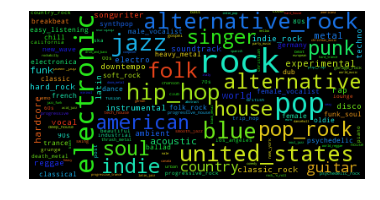

In [11]:
terms_con = map(lambda x: x.replace(' ', '_'), terms)
text = ' '.join(terms_con)
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=40, relative_scaling=.5)
pic = wordcloud.generate(text)
plt.imshow(pic)
plt.axis("off")
plt.show()

### Fun fact: What words artists like most to use in their song titles

Using the word cloud, we can also do some interesting data mining and visualize it. For example, when we are listening to a song and looking into the title of the song, we can always find some words are often used. In the following snippet, we are going to present what words are often used in composing the title of the song.

#### Pre processing

First of all, we must declare the stop words in the title. In song titles, the following patterns is quite common: 'Live edition', 'album edition', 'remix', 'featuring'. These words actually not a part of the title. So we need to add them to the stopwords of the word cloud. The WordCloud package has already provided some stop words, but we need to add these additional stopwords in the song title case.

In [12]:
from wordcloud import STOPWORDS

stopwords = STOPWORDS.copy()
stopwords.add('album')
stopwords.add('live')
stopwords.add('remix')
stopwords.add('digital')
stopwords.add('version')

After defining the stopwords, the rest of this part is quite easy. Since we have already got all the artists and their 
song titles in previous part, we can just reuse these parts. Then we tokenize and lemminize these titles to get the full 
list of words used in the song titles. Finally we can generate the wordcloud.

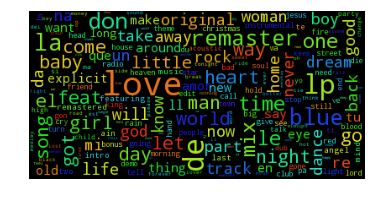

In [13]:
import re
import nltk
import string

def process(titles):
    text = ' '.join(titles)
    lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
    text = text.lower()
    text = re.sub('['+re.escape(string.punctuation)+']', ' ', text)
    words = nltk.word_tokenize(text)
    w = []
    for word in words:
        word = word.strip(string.punctuation)
        try:
            tmp = lemmatizer.lemmatize(word)
            if tmp:
                w.append(str(tmp))
        except:
            pass
    return w


song_titles = []
for titles in artist_songs.values():
    song_titles += titles
all_title_words = process(song_titles)
text = ' '.join(all_title_words)

wordcloud = WordCloud(max_font_size=40, relative_scaling=.5, stopwords=stopwords)
pic = wordcloud.generate(text)
plt.imshow(pic)
plt.axis("off")
plt.show()


## K-NN and Song Year Prediction

The Million Song Database does not only provide the metadata of the songs but also accoustic features like tempo, timbre, loudness information.  Using these information, we can predict many facts about the songs like genre using the tempo, the distribution of energy in the song and the timbre of each segment of the song. But it requires a lot of computation power. Here in this section, we are using some scale data to predict the year a song is composed. 

### Feature Extraction

The feature we choose here are the average timbre in each section of the song, the average pitch in each section of the song, the tempo of the song and the energy of the song. Timbre and pitch feature is vectors and the other two are scala value. 

In [14]:
import numpy as np

# Get the title of all songs and the artist of it
features = []
tags = []
years = []

def extract_feature(f):
    h5 = GETTERS.open_h5_file_read(f)
    num_songs = GETTERS.get_num_songs(h5)
    for i in range(num_songs):
        y = GETTERS.get_year(h5, i)
        if y == 0:
            # Skip all songs which year is not labeled
            continue
        timbre = GETTERS.get_segments_timbre(h5, i).mean(axis=0)
        pitch = GETTERS.get_segments_pitches(h5, i).mean(axis=0)
        tempo = GETTERS.get_tempo(h5, i)
        energy = GETTERS.get_energy(h5, i)
        feature = list(timbre) + list(pitch) + [energy, tempo]
        features.append(feature)
        t = GETTERS.get_artist_terms(h5, i)
        tags.append(t)
        years.append(y)
    h5.close()
apply_to_all_files(MSD_path, extract_feature)

features = np.array(features)

# number of artists
print features.shape

(4680L, 26L)


### Quick Nearest Neighbor Search on Large dataset

As we can see in the shape of the features above, every feature of the song has 24 dimensions and there are thousands of data points, the traditional KNN will cost huge amount of memory and time computing the nearest neighbor. So we use ANN (Approximate nearest neighbor) here which doesn't guarantee to return the actual nearest neighbor in every case, in return for improved speed or memory savings. Because this tutorial is mainly focused on the Million Song Dataset not on the algorithm, we use the FLANN library to do Approximate nearest neighbor searching.

In [15]:
from pyflann import *

total_num = features.shape[0]
train_num = total_num * 9 / 10
train_set = features[:train_num]
train_year = years[:train_num]
test_set = features[train_num:]
test_year = years[train_num:]

def run_test(train_set, test_set):
    flann = FLANN()
    result, _ = flann.nn(
        train_set, test_set, 20, algorithm="kmeans", branching=16, iterations=20, checks=16)
    return result


In [21]:
def verify(result, train_year, test_year, delta=5):
    hit = 0
    num_tests = len(result)
    for idx in range(num_tests):
        predicted = [train_year[x] for x in result[idx]]
        if any(abs(x - test_year[idx]) <= delta for x in predicted[:5]):
            hit += 1
    return float(hit) / num_tests

result = run_test(train_set, test_set)
print verify(result, train_year, test_year)

0.824786324786


This is the end of the tutorial for Million Data Set. This tutorial covers some basic facets of the dataset, but the Million Song Dataset is much more than these. The dataset also includes some accoustic data of each song and other meta infos, which are very useful in big data researches and engineering. Things like song recommendation, song similarity examine etc are enabled using these dataset. For we are using python here (which is not good at big data processing) the examples here are only run on the subset of the dataset. But you can find much more on the official website of Million Song Dataset. Thank you!